In [1]:
from transformers import GPT2Model

In [2]:
model = GPT2Model.from_pretrained("gpt2-xl")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from operator import attrgetter
def analyze_weights(model_name, model, dist_range=None, layer_names=['h']):
    parameters = torch.cat([p.flatten() for p in model.parameters()])
    hist, bin_edges = torch.histogram(torch.abs(parameters), bins=250, range=dist_range)
    bin_edges = bin_edges.detach().numpy()
    hist = hist.detach().numpy()
    width = np.diff(bin_edges)
    plt.bar(bin_edges[:-1], hist, width=width)
    plt.title("Distribution of weight magnitudes for " + model_name)
    plt.xlabel("Log Absolute Value")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.show()
    
    dist = np.cumsum(hist / hist.sum(), 0)
    plt.plot(bin_edges[:-1], dist)
    plt.title("CDF of weight magnitudes for " + model_name)
    plt.xlabel("Log Absolute Value")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.show()
    
    for layer_name in layer_names:
        for idx, layer in enumerate(attrgetter(layer_name)(model)):
            parameters = torch.cat([p.flatten() for p in layer.parameters()])
            hist, bin_edges = torch.histogram(torch.abs(parameters), bins=250, range=dist_range)
            bin_edges = bin_edges.detach().numpy()
            hist = hist.detach().numpy()
            dist = np.cumsum(hist / hist.sum(), 0)
            plt.plot(bin_edges[:-1], dist, label= layer_name + " layer " + str(idx))
    plt.title("CDF of weight magnitudes by layer for " + model_name)
    plt.xlabel("Log Absolute Value")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()
    

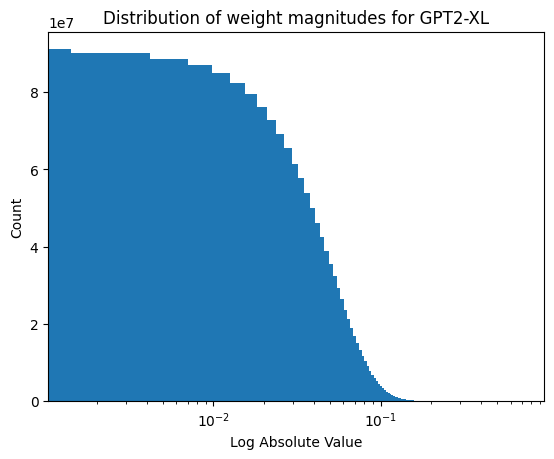

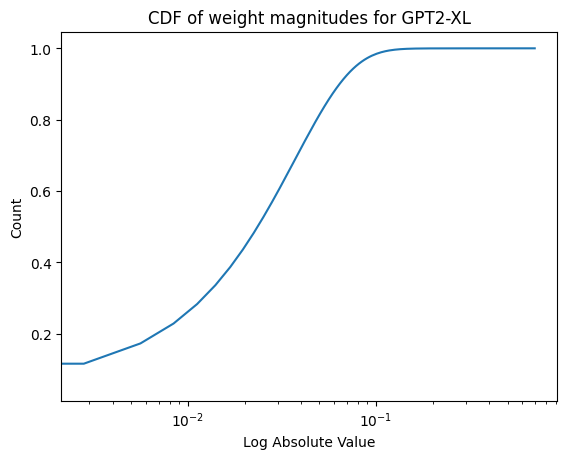

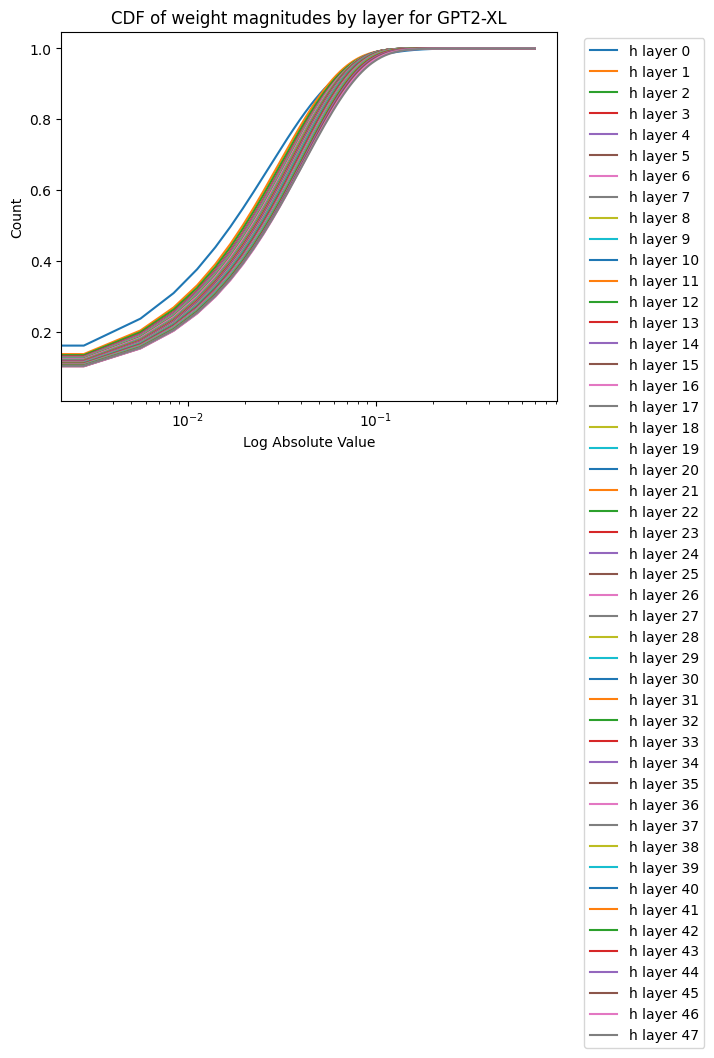

In [93]:
analyze_weights("GPT2-XL", model, (0, 0.7))

In [87]:
from transformers import T5Model
t5model = T5Model.from_pretrained("google/t5-v1_1-xl")

Some weights of the model checkpoint at google/t5-v1_1-xl were not used when initializing T5Model: ['lm_head.weight']
- This IS expected if you are initializing T5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


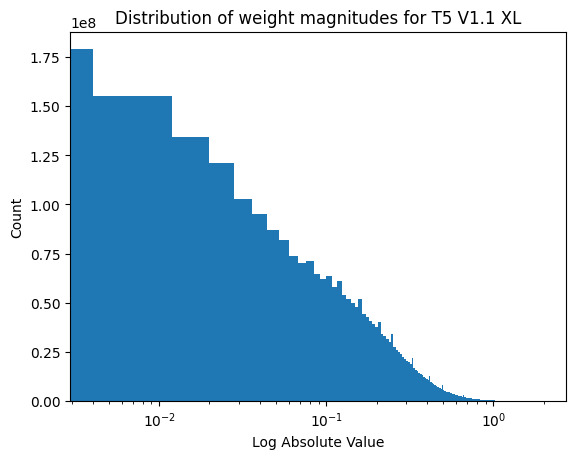

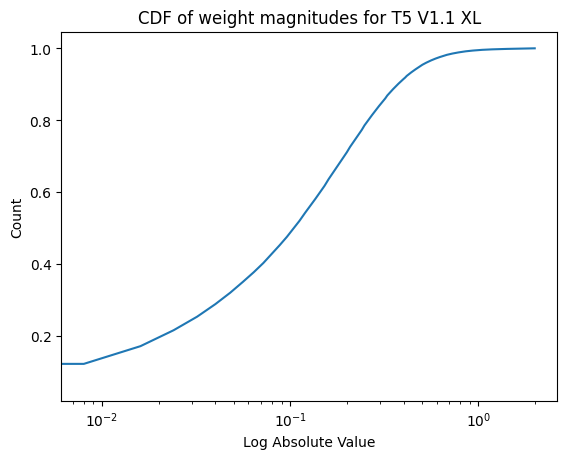

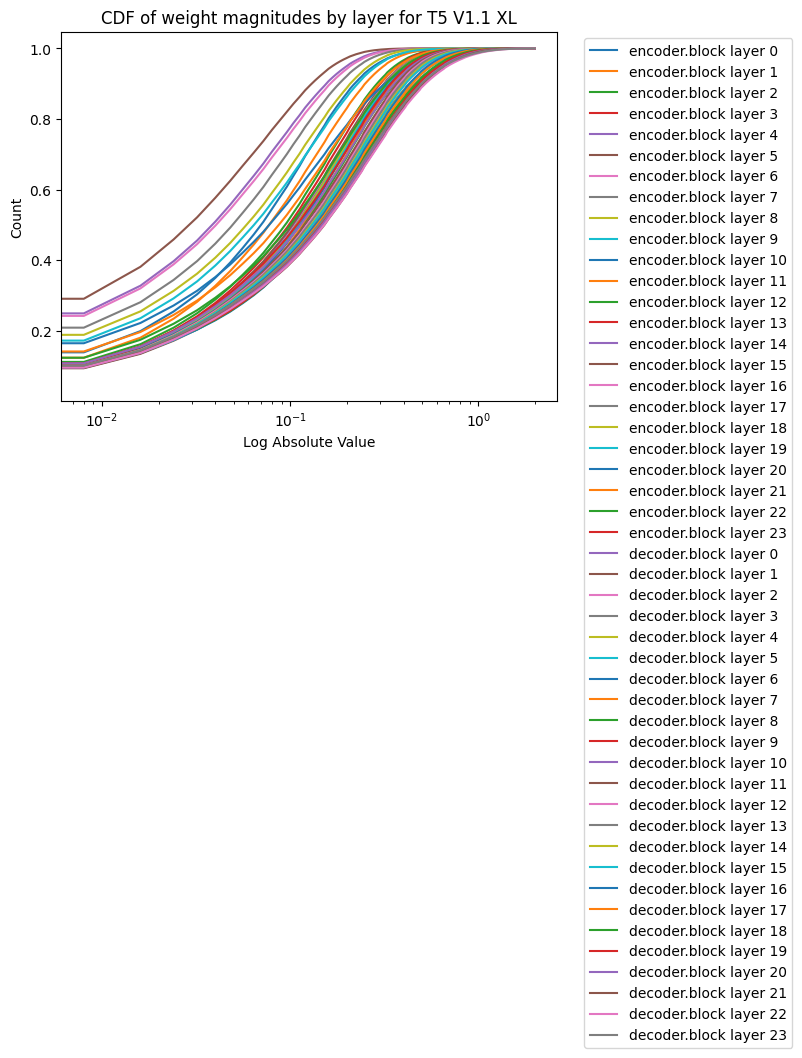

In [96]:
analyze_weights("T5 V1.1 XL", t5model, (0, 2), ['encoder.block', 'decoder.block'])

In [84]:
t5model.encoder.block

ModuleList(
  (0): T5Block(
    (layer): ModuleList(
      (0): T5LayerSelfAttention(
        (SelfAttention): T5Attention(
          (q): Linear(in_features=2048, out_features=2048, bias=False)
          (k): Linear(in_features=2048, out_features=2048, bias=False)
          (v): Linear(in_features=2048, out_features=2048, bias=False)
          (o): Linear(in_features=2048, out_features=2048, bias=False)
          (relative_attention_bias): Embedding(32, 32)
        )
        (layer_norm): T5LayerNorm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): T5LayerFF(
        (DenseReluDense): T5DenseGatedActDense(
          (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
          (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
          (wo): Linear(in_features=5120, out_features=2048, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (act): NewGELUActivation()
        )
        (layer_norm): T5LayerNorm()
        (d

In [97]:
from transformers import XLNetModel
xlnetmodel = XLNetModel.from_pretrained("xlnet-large-cased")

Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
xlnetmodel

XLNetModel(
  (word_embedding): Embedding(32000, 1024)
  (layer): ModuleList(
    (0): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
        (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        

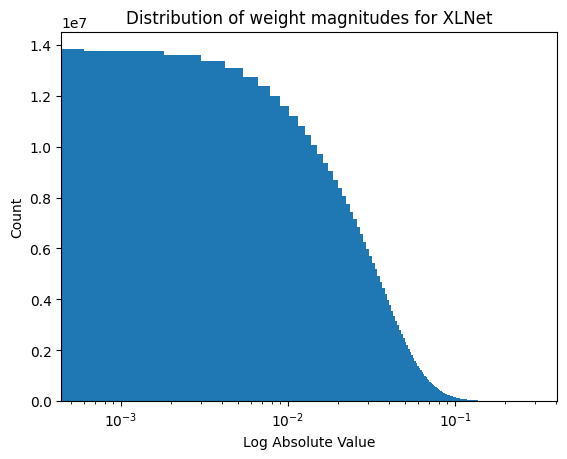

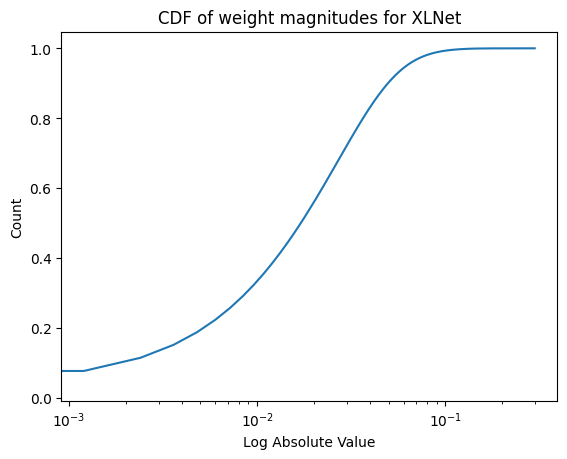

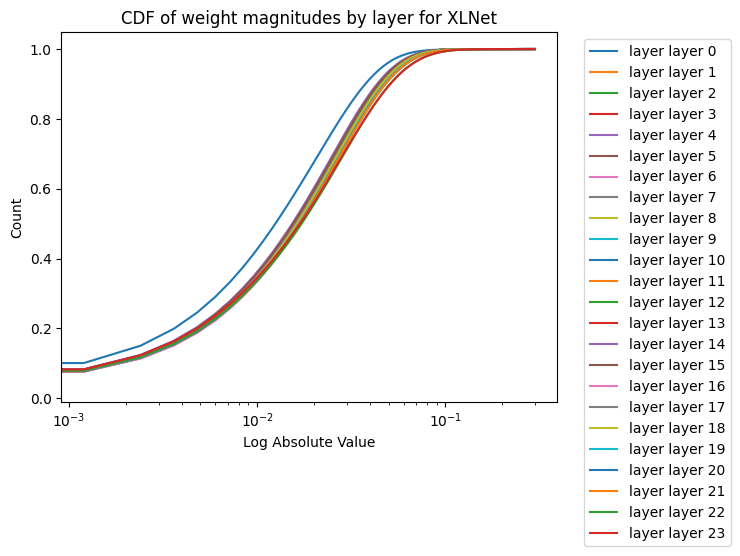

In [102]:
analyze_weights("XLNet", xlnetmodel, (0, 0.3), ['layer'])

In [1]:
from torch.nn.utils import prune

def prune_weights(model, to_prune=0.1):
    def get_weight_names(layer):
        weight_names = []
        if len(list(layer.children())) > 0:
            for child in layer.children():
                if not list(child.children()):
                    for p in child.named_parameters():
                        if 'weight' in p[0]:
                            weight_names.append((child, p[0]))
                else:
                    weight_names.extend(get_weight_names(child))
        
        
        return weight_names
    
    weights = get_weight_names(model)
    
    prune.global_unstructured(weights, pruning_method=prune.L1Unstructured, amount=to_prune)
    
    for layer, name in weights:
        prune.remove(layer, name)
    return model

In [4]:
model = GPT2Model.from_pretrained("gpt2-xl")
model_pruned = prune_weights(model, to_prune=0.99)

In [6]:
model_pruned.save_pretrained("./sparse/gpt2-xl.99")

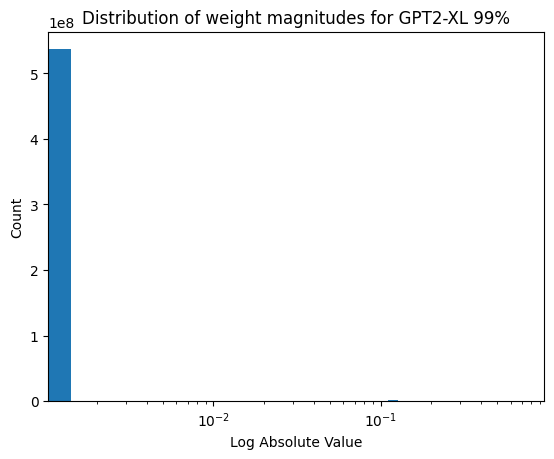

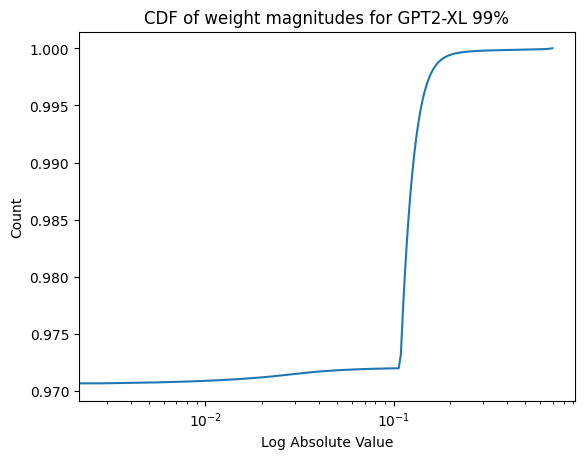

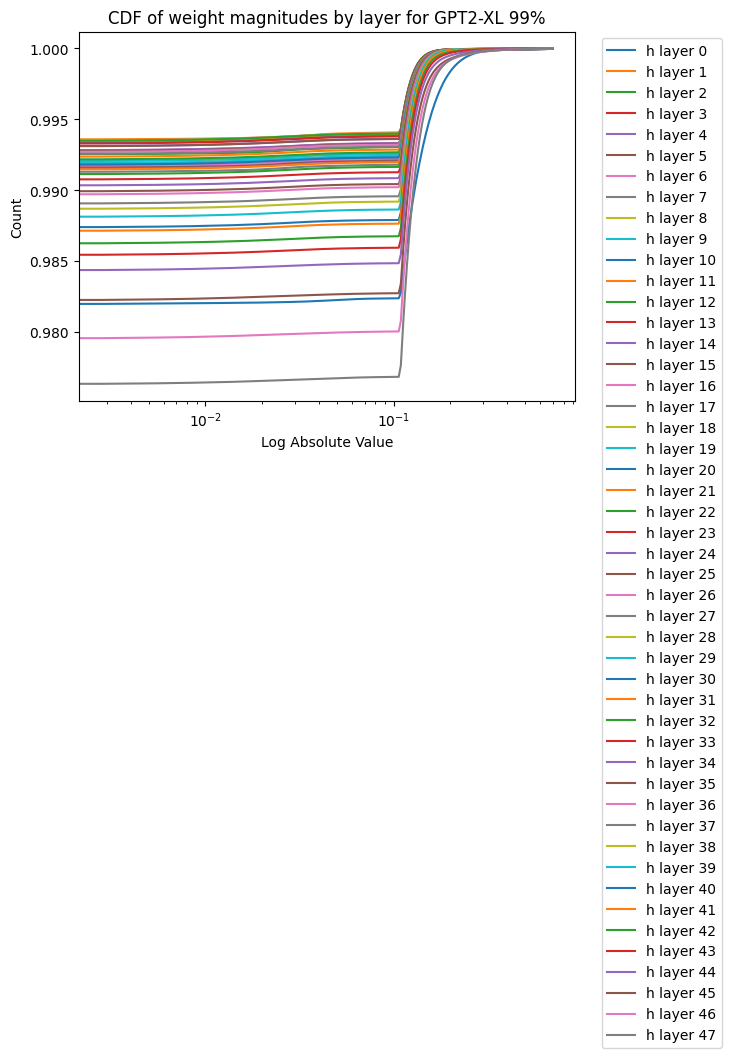

In [9]:
analyze_weights("GPT2-XL 99%", model_pruned, (0, 0.7))

In [2]:
from transformers import XLNetModel, GPT2Model, BertModel
import copy
# gpt2 = GPT2Model.from_pretrained("gpt2")
# xlnet = XLNetModel.from_pretrained("xlnet-base-cased")
bertmodel = BertModel.from_pretrained("bert-large-cased")
for model, model_name in [(bertmodel, 'bert')]:
    print("Now beginning pruning for model " + model_name)
    for sparsity in [0.1, 0.5, 0.9, 0.95, 0.99]:
        model_to_prune = copy.deepcopy(model) 
        model_pruned = prune_weights(model_to_prune, to_prune=sparsity)
        model_pruned.save_pretrained(f"./sparse/{model_name}.{sparsity}")

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now beginning pruning for model bert


In [19]:
%debug

> /var/tmp/pbs.350231.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_37992/2790969386.py(5)get_weight_names()
      3     if len(list(layer.children())) > 0:
      4         for child in layer.children():
----> 5             weight_names += get_weight_names(child)
      6     for p in layer.named_parameters():
      7         print(p)

ipdb> child
Embedding(50257, 1600)
ipdb> layer
GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (

ipdb> layer.named_parameters()
<generator object Module.named_parameters at 0x1466c6ed3970>
ipdb> layer.children()
<generator object Module.children at 0x1466c6ed3580>
ipdb> exit
